# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants
import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


In [4]:
import constants
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

COLOR_PALETTE = constants.COLOR_MAPPING_DEEP

# Plot

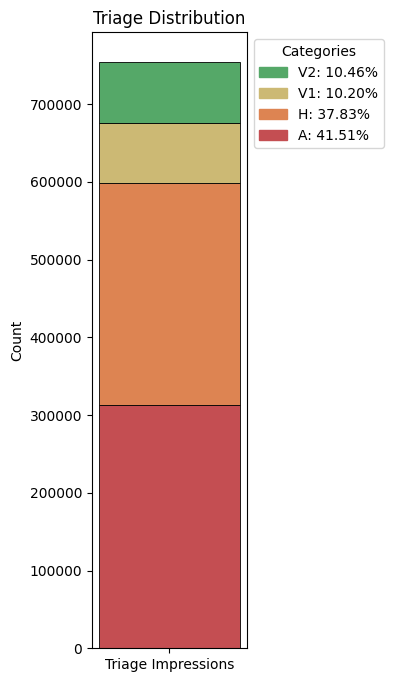

In [5]:
# Sample DataFrame, replace with your actual DataFrame
df = data_loader.processed_incidents_df

# Define categories and get counts
categories = ['A', 'H', 'V1', 'V2']
triage_counts = df['triage_impression_during_call'].value_counts()

# Initialize variables
bottom = 0
total_count = sum([triage_counts.get(cat, 0) for cat in categories])
legend_labels = []
legend_colors = []

plt.figure(figsize=(2, 8))

# Create the stacked bar chart
for cat in categories:
    count = triage_counts.get(cat, 0)
    percentage = (count / total_count) * 100
    label = f"{cat}: {percentage:.2f}%"
    
    plt.bar('Triage Impressions', count, bottom=bottom, color=COLOR_PALETTE[cat], edgecolor='black', linewidth=0.6)
    bottom += count
    
    # Store labels and colors for legend
    legend_labels.append(label)
    legend_colors.append(COLOR_PALETTE[cat])

# Add labels and title
plt.yticks(range(0, bottom+1, 100000))  # Adjust the yticks as needed
plt.ylabel('Count')
plt.title('Triage Distribution')

# Add legend
# Reverse the labels and colors to have 'A' at the bottom and 'V2' at the top in the legend
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in reversed(legend_colors)], 
           labels=reversed(legend_labels), title='Categories', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


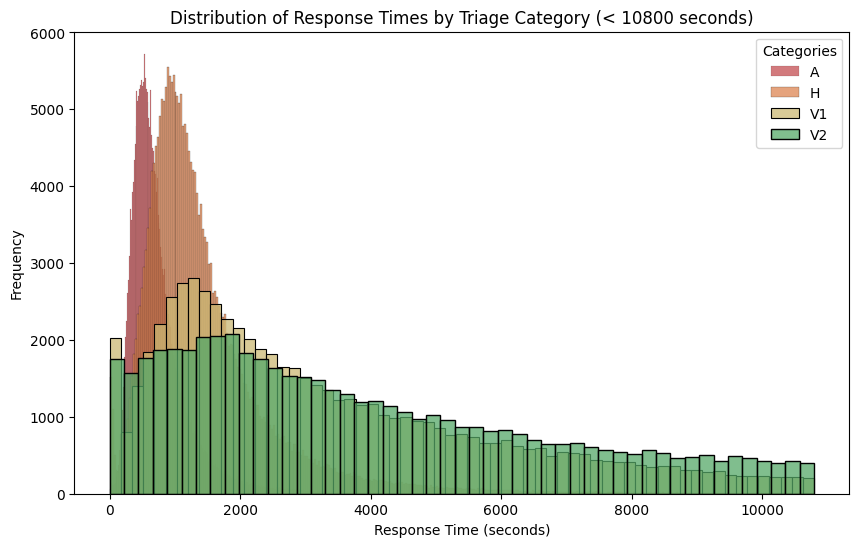

In [6]:
# Initialize figure
plt.figure(figsize=(10, 6))

new_df = df

# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 10800) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}

# Plot histogram for each category using the custom color palette
for cat in categories:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()

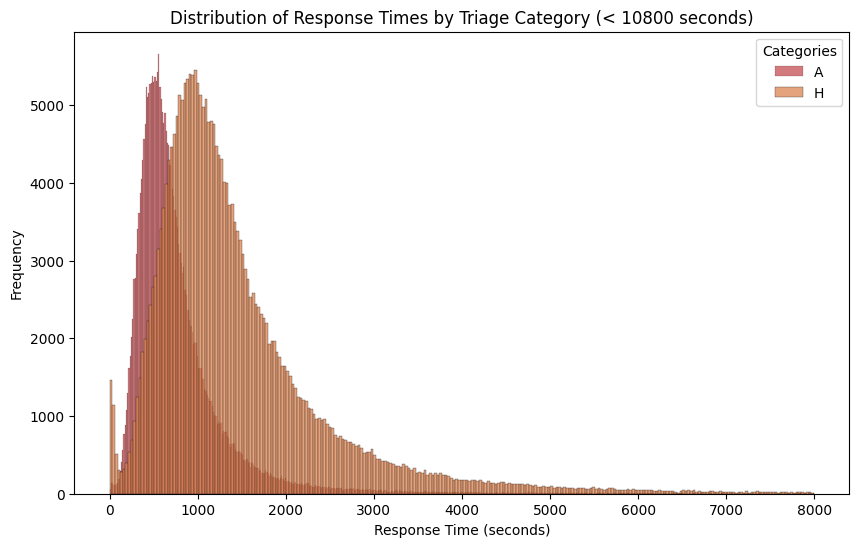

In [7]:
# Initialize figure
plt.figure(figsize=(10, 6))

new_df = df
categories = ['A', 'H']
# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 8000) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}

# Plot histogram for each category using the custom color palette
for cat in categories:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()

## How many rows have a negative response time?

In [8]:

df_copy = data_loader.processed_incidents_df.copy()

negative_response_time_count = df_copy[df_copy['response_time_sec'] < 0].shape[0]

print(negative_response_time_count)

7910


## How to do Quantiles?

In [9]:
def generate_quantiles(num_quartiles):
    step = 1 / num_quartiles
    return [round(step * i, 2) for i in range(1, num_quartiles)]


num_quartiles = 10

quantiles = df_copy['response_time_sec'].quantile(generate_quantiles(num_quartiles))

quantiles

0.1     383.0
0.2     528.0
0.3     662.0
0.4     812.0
0.5     993.0
0.6    1230.0
0.7    1581.0
0.8    2260.0
0.9    4298.0
Name: response_time_sec, dtype: float64

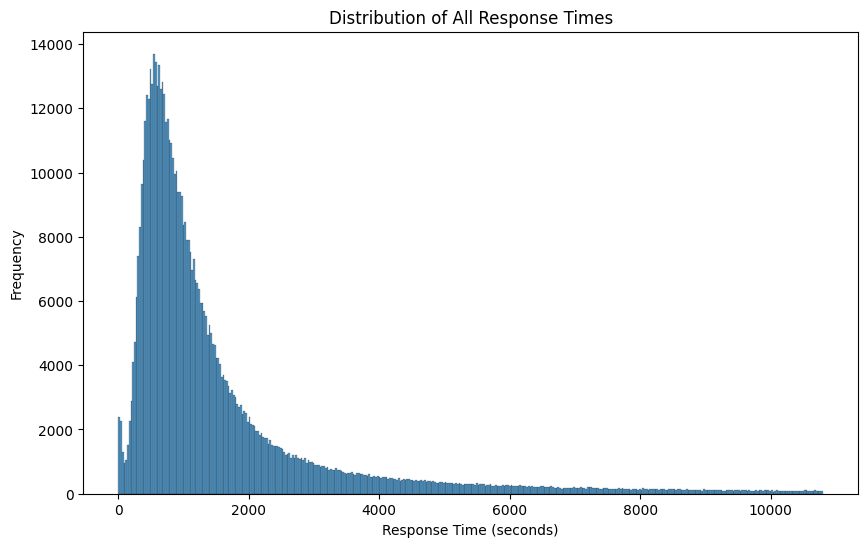

In [10]:
plt.figure(figsize=(10, 6))

# Pre-filter data for response_time_sec < 10800 and response_time_sec > 0
filtered_data = df_copy[(df_copy['response_time_sec'] < 10800) & (df_copy['response_time_sec'] > 0)]['response_time_sec']

# Plot histogram
sns.histplot(filtered_data, kde=False)

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of All Response Times')

# Show the plot
plt.show()

In [11]:
df_sample = df

time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
df_sample[time_columns] = df_sample[time_columns].apply(pd.to_datetime, errors='coerce', format="%Y.%m.%dT%H:%M:%S")

stats_dict_bad_values = {}

# Loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df = df_sample[df_sample[col1] > df_sample[col2]]
    
    if not filtered_df.empty:
        # Calculate the time difference in seconds
        time_diff_series = (filtered_df[col1] - filtered_df[col2]).dt.total_seconds()
        
        # Calculate mean, median, and mode
        mean_time_diff = time_diff_series.mean()
        median_time_diff = time_diff_series.median()
        mode_time_diff = time_diff_series.mode()[0]  # Taking the first mode

        # Store the statistics in the dictionary
        stats_dict_bad_values[f"{col1} > {col2}"] = {
            'mean': mean_time_diff,
            'median': median_time_diff,
            'mode': mode_time_diff
        }

# Display the statistics
stats_dict_bad_values

{'time_call_received > time_call_processed': {'mean': 40544.35300698498,
  'median': 8478.0,
  'mode': 1.0},
 'time_call_processed > time_ambulance_notified': {'mean': 1074.7022632674298,
  'median': 14.0,
  'mode': 1.0},
 'time_ambulance_notified > time_dispatch': {'mean': 22743.30769230769,
  'median': 72.0,
  'mode': 5.0},
 'time_dispatch > time_arrival_scene': {'mean': 65480.470588235294,
  'median': 13685.5,
  'mode': 409.0},
 'time_arrival_scene > time_departure_scene': {'mean': 49846.0,
  'median': 49846.0,
  'mode': 13652.0},
 'time_departure_scene > time_arrival_hospital': {'mean': 2463.0,
  'median': 2463.0,
  'mode': 2321.0},
 'time_arrival_hospital > time_available': {'mean': 4987.558823529412,
  'median': 694.5,
  'mode': 85.0}}

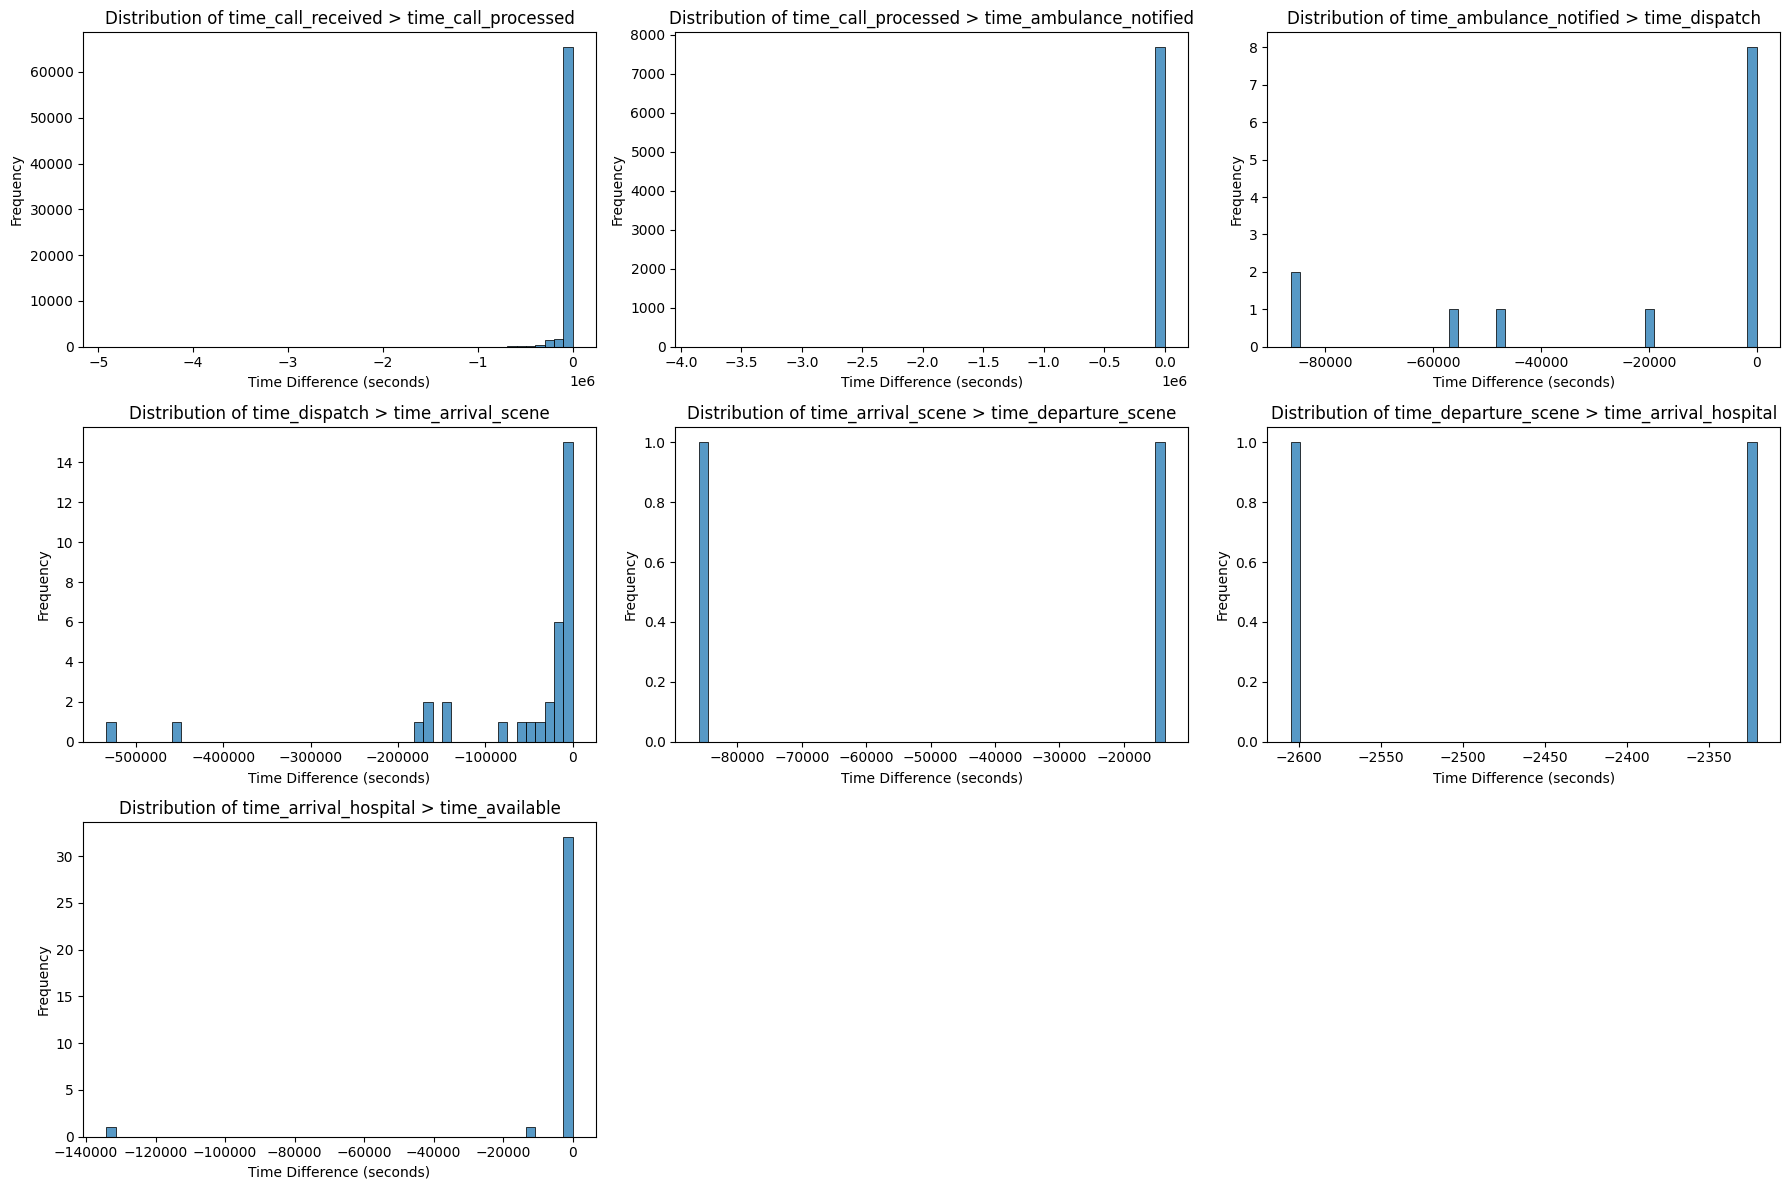

In [12]:

import pandas as pd

test_df = data_loader.enhanced_incidents_df

# Convert all time columns to datetime format
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
# Initialize the figure
plt.figure(figsize=(18, 12))

# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_bad_values.items()):
    col1, col2 = key.split(" > ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_bad = (df_sample[df_sample[col1] > df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] > df_sample[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_bad, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Initialize a dictionary to keep the statistics for "good" datetime values
stats_dict_good_values = {}

# Loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df_good = df_sample[df_sample[col1] <= df_sample[col2]]
    
    if not filtered_df_good.empty:
        # Calculate the time difference in seconds
        time_diff_series_good = (filtered_df_good[col2] - filtered_df_good[col1]).dt.total_seconds()
        
        # Calculate mean, median, and mode
        mean_time_diff_good = time_diff_series_good.mean()
        median_time_diff_good = time_diff_series_good.median()
        mode_time_diff_good = time_diff_series_good.mode()[0]  # Taking the first mode

        # Store the statistics in the dictionary
        stats_dict_good_values[f"{col1} <= {col2}"] = {
            'mean': mean_time_diff_good,
            'median': median_time_diff_good,
            'mode': mode_time_diff_good
        }

# Display the statistics for "good" datetime values
stats_dict_good_values

{'time_call_received <= time_call_processed': {'mean': 3092.4574450072255,
  'median': 103.0,
  'mode': 45.0},
 'time_call_processed <= time_ambulance_notified': {'mean': 4719.085000234381,
  'median': 83.0,
  'mode': 4.0},
 'time_ambulance_notified <= time_dispatch': {'mean': 124.86481150019075,
  'median': 71.0,
  'mode': 4.0},
 'time_dispatch <= time_arrival_scene': {'mean': 627.0227795854423,
  'median': 483.0,
  'mode': 2.0},
 'time_arrival_scene <= time_departure_scene': {'mean': 1212.8019762015654,
  'median': 1070.0,
  'mode': 2.0},
 'time_departure_scene <= time_arrival_hospital': {'mean': 1107.6658121633004,
  'median': 862.0,
  'mode': 2.0},
 'time_arrival_hospital <= time_available': {'mean': 1835.7715002114892,
  'median': 864.0,
  'mode': 2.0}}

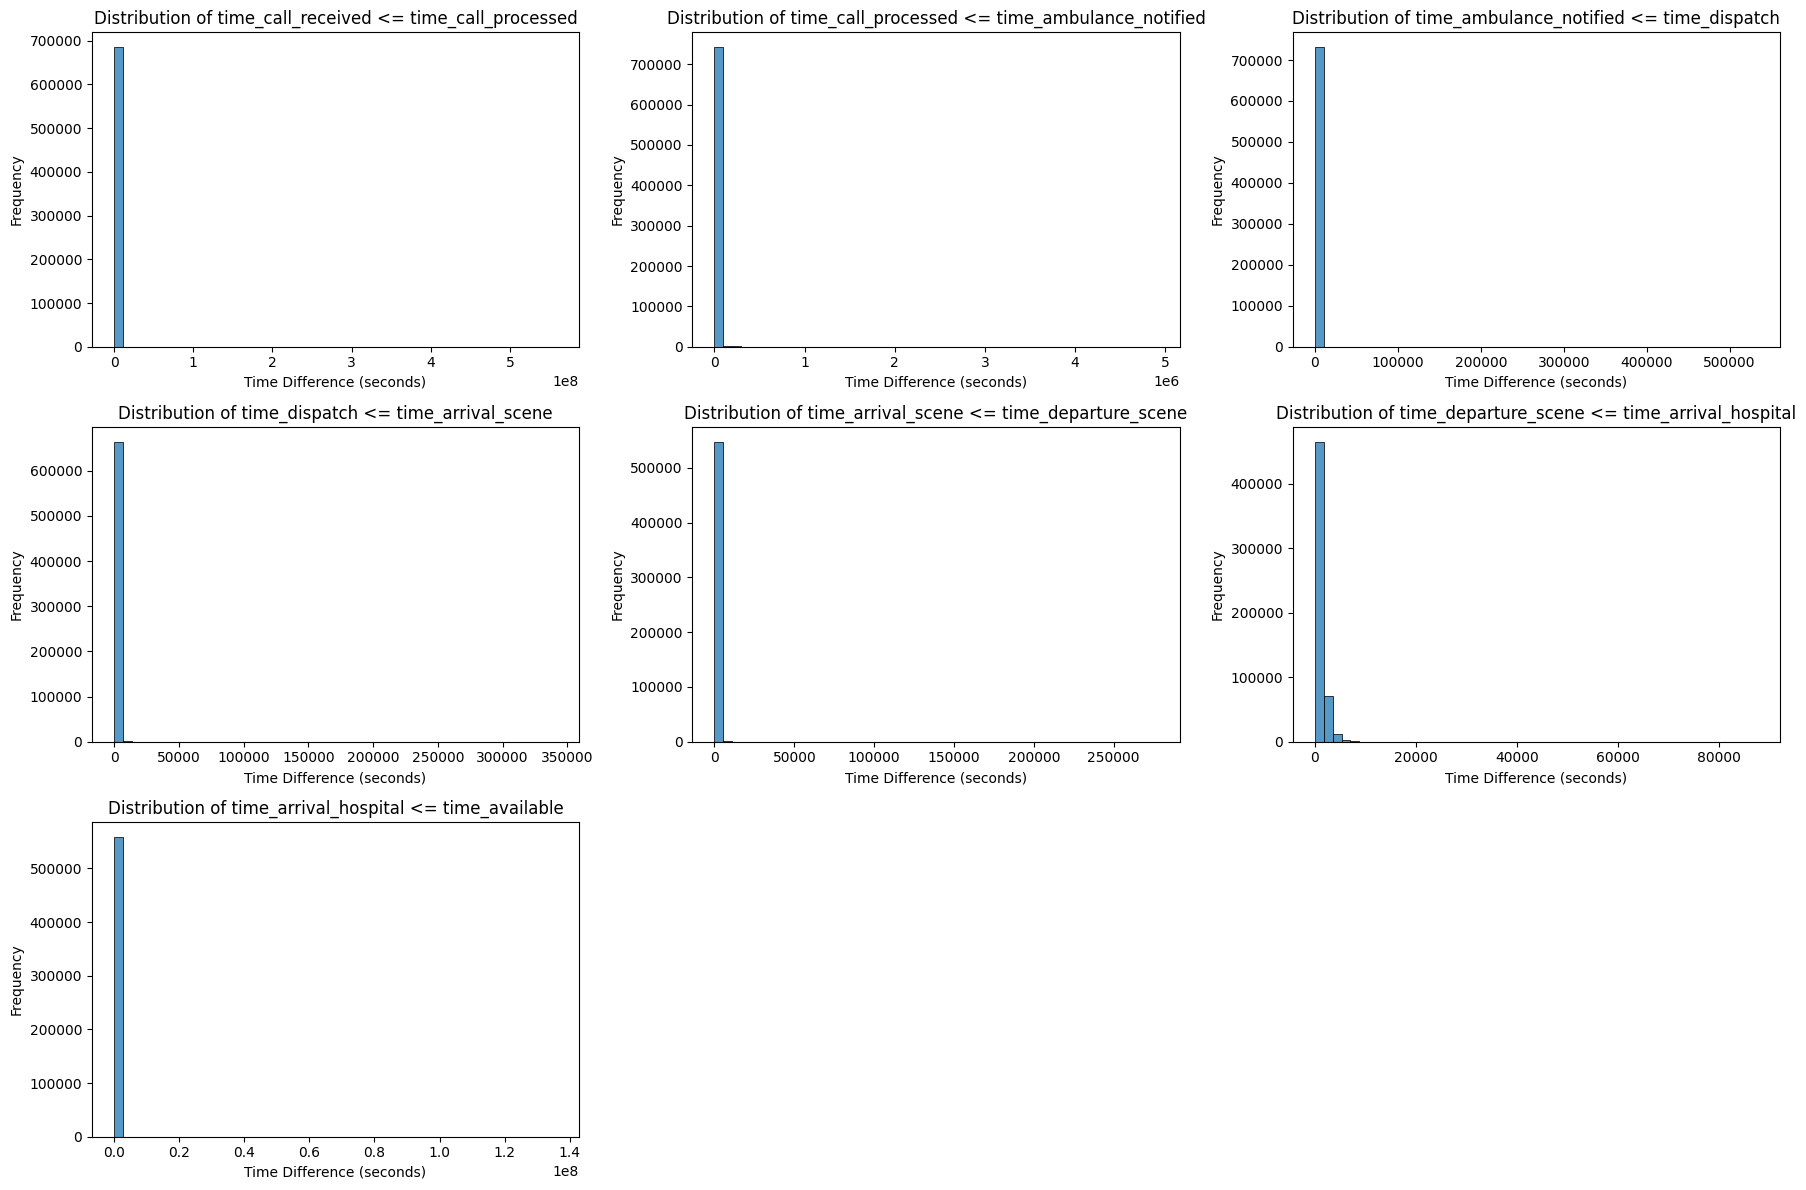

In [14]:
# Initialize the figure
plt.figure(figsize=(18, 12))

# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_good_values.items()):
    col1, col2 = key.split(" <= ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_good = (df_sample[df_sample[col1] <= df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] <= df_sample[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_good, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [15]:
# Create a sample DataFrame for demonstration; replace this with your actual data


df_sample = df

# Define time columns and a dictionary to store the quantile information
quantile_info = {}

# Calculate time differences in seconds and then divide into 5 quantiles
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    
    # Calculate time difference for good values in seconds
    time_diff_series_good = (df_sample[df_sample[col1] <= df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] <= df_sample[col2]][col1]).dt.total_seconds()
    
    
    # Divide the time differences into 5 quantiles
    quantiles = time_diff_series_good.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    
    # Store the quantile information
    quantile_info[f"{col1} <= {col2}"] = quantiles

quantile_info

{'time_call_received <= time_call_processed': 0.1           27.0
 0.2           45.0
 0.3           62.0
 0.4           80.0
 0.5          103.0
 0.6          133.0
 0.7          179.0
 0.8          267.0
 0.9          571.0
 1.0    559528824.0
 dtype: float64,
 'time_call_processed <= time_ambulance_notified': 0.1         10.0
 0.2         20.0
 0.3         32.0
 0.4         50.0
 0.5         83.0
 0.6        149.0
 0.7        326.0
 0.8       1070.0
 0.9       5259.0
 1.0    4914937.0
 dtype: float64,
 'time_ambulance_notified <= time_dispatch': 0.1         4.0
 0.2         7.0
 0.3        18.0
 0.4        50.0
 0.5        71.0
 0.6        90.0
 0.7       112.0
 0.8       146.0
 0.9       215.0
 1.0    534073.0
 dtype: float64,
 'time_dispatch <= time_arrival_scene': 0.1       122.0
 0.2       231.0
 0.3       317.0
 0.4       399.0
 0.5       483.0
 0.6       582.0
 0.7       704.0
 0.8       886.0
 0.9      1219.0
 1.0    341981.0
 dtype: float64,
 'time_arrival_scene <= time_depar